In [1]:
!pip install -q transformers

In [192]:
from collections import Counter

import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing

from bs4 import BeautifulSoup
import requests

import re

import os
import time
import pickle
import copy

from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import matplotlib.pyplot as plt

from google.colab import drive

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/project/final_simple_project_data.csv', index_col=0)

In [5]:
with open('/content/drive/MyDrive/project/nested_reviews.pkl', 'rb') as file:
    nested_reviews = pickle.load(file)

In [6]:
df.head()

,title,oscar_win,raw_reviews
0,Hustle & Flow,0,Miss Wood has a beauty and radiance that carry...
1,Art and Craft,0,One of the most complex and powerful literary ...
2,Shall We Kiss?,0,A delectably naughty experience. This sort of ...
3,The Barbarian Invasions,0,This suspenseful drama reveals pieces of its p...
4,Life During Wartime,0,Roberts and Erin Brockovich have Oscar contend...


In [7]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [8]:
??model

In [9]:
??tokenizer

In [10]:
text = ["Hello, my dog is cute, but it poo's and it stinks often. However, I love it",
        "Hiii, My name is Stepan"]
inputs = tokenizer(text, return_tensors="pt", padding='longest')
inputs.to(device)
distilbert_output = model.distilbert(**inputs)

In [11]:
inputs.input_ids.shape

torch.Size([2, 26])

In [12]:
hidden_state = distilbert_output[0]

In [13]:
hidden_state.shape

torch.Size([2, 26, 768])

In [14]:
pooled_output = hidden_state[:, 0]  # (bs, dim)
# pooled_output = torch.mean(hidden_state, dim=1)
print(pooled_output.shape)
pooled_output = model.pre_classifier(pooled_output)  # (bs, dim)
print(pooled_output.shape)
pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
print(pooled_output.shape)
pooled_output = model.dropout(pooled_output)  # (bs, dim)
print(pooled_output.shape)
logits = model.classifier(pooled_output)  # (bs, num_labels)

torch.Size([2, 768])
torch.Size([2, 768])
torch.Size([2, 768])
torch.Size([2, 768])


In [15]:
logits[0]

tensor([ 2.2185, -1.9966], device='cuda:0', grad_fn=<SelectBackward0>)

In [16]:
predicted_class_id = logits[0].argmax().item()
model.config.id2label[predicted_class_id]

'NEGATIVE'

In [17]:
predicted_class_id = logits[1].argmax().item()
model.config.id2label[predicted_class_id]

'POSITIVE'

In [18]:
nested_reviews[0][0]

'Miss Wood has a beauty and radiance that carry her through a role of violent passions and depressions with unsullied purity and strength. There is poetry in her performance, and her eyes in the final scene bespeak the moral significance and emotional fulfillment of this film.'

In [19]:
# hidden_states_list = []

# for i, reviews in enumerate(nested_reviews):

#     with torch.no_grad():
#         inputs = tokenizer(reviews, return_tensors="pt", padding='longest')
#         inputs.to(device)
#         distilbert_output = model.distilbert(**inputs)
#         hidden_state = distilbert_output[0]
#         hidden_state = hidden_state[:, 0]
#         # Uncomment this string to get hidden states mean
#         # hidden_state = torch.mean(hidden_state, dim=0)

#     hidden_states_list.append(hidden_state)

#     if i%100==0:
#         print("Number of iteration - ", i)

#     if i % 3000 ==0:
#         with open(f'/content/drive/MyDrive/project/embeddings/all_batches_{str(i)}_iters.pkl', 'wb') as file:
#             pickle.dump(hidden_states_list, file)

#         del hidden_states_list
#         torch.cuda.empty_cache()
#         hidden_states_list = []

In [20]:
# with open('/content/drive/MyDrive/project/embeddings/mean_for_batch.pkl', 'wb') as file:
#     pickle.dump(hidden_states_list, file)

In [21]:
# del hidden_states_list

In [22]:
torch.cuda.empty_cache()

# Load embeddings

In [69]:
with open('/content/drive/MyDrive/project/embeddings/mean_for_batch.pkl', 'rb') as file:
    embedding_list = pickle.load(file)

## SVM Model with embeddings

In [70]:
len(embedding_list)

12029

In [71]:
numpy_embedding_list = [t_embed.detach().cpu().numpy() for t_embed in embedding_list]
numpy_embedding_list = np.array(numpy_embedding_list)

In [72]:
numpy_embedding_list.shape

(12029, 768)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(numpy_embedding_list ,df['oscar_win'], test_size=0.15)

In [74]:
svc = SVC(random_state=101)
svc.fit(X_train,y_train)

SVC(random_state=101)

In [75]:
class_names = ['non oscar winners', 'oscar winners']

In [76]:
def display_confusion_matrix(model,X_test, y_test, class_names):
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

Confusion matrix, without normalization
[[1775    0]
 [  30    0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


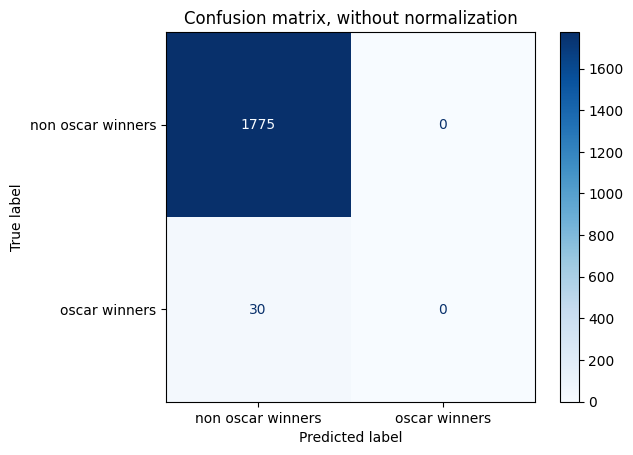

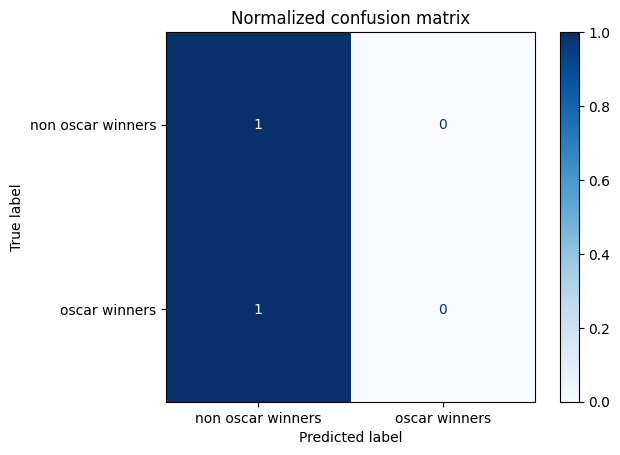

In [77]:
display_confusion_matrix(model=svc,
                         X_test=X_test,
                         y_test=y_test,
                         class_names=class_names)

In [78]:
y_pred = svc.predict(X_test)

In [80]:
report = classification_report(y_test,y_pred,target_names=class_names)
print(report)

                   precision    recall  f1-score   support

non oscar winners       0.98      1.00      0.99      1775
    oscar winners       0.00      0.00      0.00        30

         accuracy                           0.98      1805
        macro avg       0.49      0.50      0.50      1805
     weighted avg       0.97      0.98      0.98      1805



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural Network model

In [83]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(768, 256)  # Input dimension: 768, Output dimension: 256
        self.fc2 = nn.Linear(256, 128)  # Input dimension: 256, Output dimension: 128
        self.fc3 = nn.Linear(128, 1)   # Input dimension: 128, Output dimension: 64

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.fc3(x)
        return x

# Create an instance of the model
model = CustomModel()

# Example input tensor with 768 dimensions
input_tensor = torch.randn(1, 768)  # Assuming batch size of 1

# Pass the input tensor through the model
output = model(input_tensor)
print(output.shape)  # This will print the shape of the output tensor

torch.Size([1, 1])


#### Change type to torch and use gpu

In [84]:
y_train_list = y_train.tolist()
y_test_list = y_test.tolist()

In [85]:
X_train_nn = torch.tensor(X_train, device=device)
X_test_nn = torch.tensor(X_test, device=device)
y_train_nn = torch.tensor(y_train_list, device=device)
y_test_nn = torch.tensor(y_test_list, device=device)

#### Train loop

In [86]:
# Change types
y_train_nn = y_train_nn.to(torch.float16)
y_train_nn = y_train_nn.view(-1, 1)
y_test_nn = y_test_nn.to(torch.float16)
y_test_nn = y_test_nn.view(-1, 1)

In [117]:
# Training loop
def train_loop(model, optimizer, criterion, epochs,
               X_train_nn, X_test_nn, y_train_nn, y_test_nn):
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_train_nn)

        # Compute loss
        loss = criterion(outputs, y_train_nn)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0 or epoch == 0:
            with torch.no_grad():
                val_outputs = model(X_test_nn)
                val_loss = criterion(val_outputs, y_test_nn)
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item()}, Val loss: {val_loss}')

    print('Training complete!')

In [119]:
# Create an instance of the model
model = CustomModel()
model = model.to(device)
# Define binary cross-entropy loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Epochs number
epochs = 250

In [120]:
train_loop(model, optimizer, criterion, epochs,
           X_train_nn, X_test_nn, y_train_nn, y_test_nn)

Epoch [10/250], Train Loss: 0.11663818359375, Val loss: 0.110595703125
Epoch [20/250], Train Loss: 0.0765380859375, Val loss: 0.06976318359375
Epoch [30/250], Train Loss: 0.07489013671875, Val loss: 0.06927490234375
Epoch [40/250], Train Loss: 0.0748291015625, Val loss: 0.068359375
Epoch [50/250], Train Loss: 0.07391357421875, Val loss: 0.0692138671875
Epoch [60/250], Train Loss: 0.0733642578125, Val loss: 0.06781005859375
Epoch [70/250], Train Loss: 0.072998046875, Val loss: 0.06817626953125
Epoch [80/250], Train Loss: 0.07275390625, Val loss: 0.067626953125
Epoch [90/250], Train Loss: 0.07257080078125, Val loss: 0.0677490234375
Epoch [100/250], Train Loss: 0.07232666015625, Val loss: 0.0673828125
Epoch [110/250], Train Loss: 0.072021484375, Val loss: 0.06732177734375
Epoch [120/250], Train Loss: 0.07177734375, Val loss: 0.06719970703125
Epoch [130/250], Train Loss: 0.0714111328125, Val loss: 0.06689453125
Epoch [140/250], Train Loss: 0.07098388671875, Val loss: 0.06671142578125
Epoch

#### *Convert tensors and build confusion matrix for neural network*

In [112]:
sigmoid_activation = torch.sigmoid

In [113]:
with torch.no_grad():
    val_outputs = model(X_test_nn)
    sigmoid_val_outputs = sigmoid_activation(val_outputs)
    # Get numpy tensors
    predicted_labels = (sigmoid_val_outputs.cpu().squeeze() > 0.5).numpy()

In [114]:
report = classification_report(y_test,predicted_labels,target_names=class_names)
print(report)

                   precision    recall  f1-score   support

non oscar winners       0.98      1.00      0.99      1775
    oscar winners       0.00      0.00      0.00        30

         accuracy                           0.98      1805
        macro avg       0.49      0.50      0.50      1805
     weighted avg       0.97      0.98      0.98      1805



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [115]:
cm = confusion_matrix(y_test, predicted_labels)
cm

array([[1775,    0],
       [  30,    0]])

#### As we can see the result is too poor for both models, which was caused by poor data for oscar winners labels. Let's try artifically upgrade data

# Upgrade dataset

#### As we can see both models are struggle to predict film that wins oscar. First issue - lack text embeddings for oscar winners. Let's try to solve this by artificially expanding dataset

In [99]:
# Uncomment if you wanna load data again
# with open('/content/drive/MyDrive/project/embeddings/mean_for_batch.pkl', 'rb') as file:
#     embedding_list = pickle.load(file)

# numpy_embedding_list = [t_embed.detach().cpu().numpy() for t_embed in embedding_list]
# numpy_embedding_list = np.array(numpy_embedding_list)
# X_train, X_test, y_train, y_test = train_test_split(numpy_embedding_list ,df['oscar_win'], test_size=0.15)

In [100]:
# Generate synthetic samples for the minority class using SMOTE
counter = Counter(y_train)
print("Before SMOTE", counter)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_synthetic, y_train_synthetic = smote.fit_resample(X_train, y_train)

counter_synthetic = Counter(y_train_synthetic)
print("After SMOTE", counter_synthetic)

Before SMOTE Counter({0: 10037, 1: 187})
After SMOTE Counter({0: 10037, 1: 10037})


#### Do the same for the test split (we will use it for neural network validation, control test would be just on X_test and y_test without wynthetic data)

In [131]:
counter = Counter(y_test)
print("Before SMOTE", counter)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_test_synthetic, y_test_synthetic = smote.fit_resample(X_test, y_test)

counter_synthetic = Counter(y_test_synthetic)
print("After SMOTE", counter_synthetic)

Before SMOTE Counter({0: 1775, 1: 30})
After SMOTE Counter({0: 1775, 1: 1775})


# Let's try again SVM and neural network models

#### SVM model

In [101]:
svc = SVC(random_state=101)
svc.fit(X_train_synthetic, y_train_synthetic)

SVC(random_state=101)

Confusion matrix, without normalization
[[1434  341]
 [   2   28]]
Normalized confusion matrix
[[0.81 0.19]
 [0.07 0.93]]


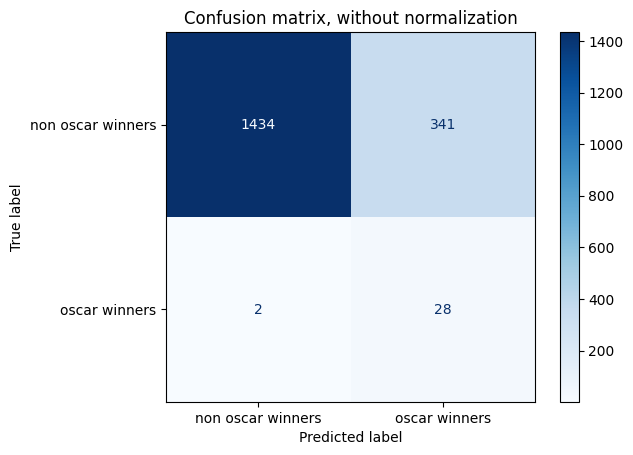

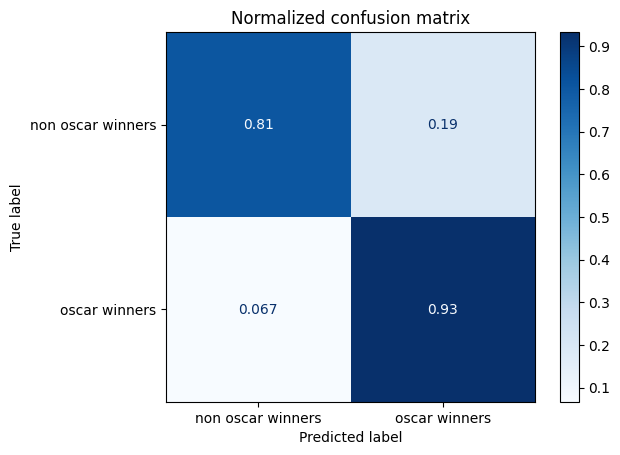

In [102]:
display_confusion_matrix(model=svc,
                         X_test=X_test,
                         y_test=y_test,
                         class_names=class_names)

In [103]:
y_pred = svc.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
acc_score

0.8099722991689751

In [104]:
report = classification_report(y_test,y_pred,target_names=class_names)
print(report)

                   precision    recall  f1-score   support

non oscar winners       1.00      0.81      0.89      1775
    oscar winners       0.08      0.93      0.14        30

         accuracy                           0.81      1805
        macro avg       0.54      0.87      0.52      1805
     weighted avg       0.98      0.81      0.88      1805



#### Linear model

In [132]:
# Convert synthetic data
X_train_synthetic_nn = torch.tensor(X_train_synthetic, device=device)
X_test_synthetic_nn = torch.tensor(X_test_synthetic, device=device)
y_train_synthetic_nn = torch.tensor(y_train_synthetic, device=device)
y_test_synthetic_nn = torch.tensor(y_test_synthetic, device=device)
# Reshape
y_train_synthetic_nn = y_train_synthetic_nn.to(torch.float16)
y_train_synthetic_nn = y_train_synthetic_nn.view(-1, 1)
y_test_synthetic_nn = y_test_synthetic_nn.to(torch.float16)
y_test_synthetic_nn = y_test_synthetic_nn.view(-1, 1)

In [167]:
# Create an instance of the model
model = CustomModel()
model = model.to(device)
# Define binary cross-entropy loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Epochs number
epochs = 260

In [168]:
train_loop(model, optimizer, criterion, epochs,
           X_train_synthetic_nn, X_test_nn, y_train_synthetic_nn, y_test_nn)

Epoch [10/260], Train Loss: 0.44384765625, Val loss: 0.4775390625
Epoch [20/260], Train Loss: 0.42333984375, Val loss: 0.45263671875
Epoch [30/260], Train Loss: 0.408203125, Val loss: 0.449462890625
Epoch [40/260], Train Loss: 0.390869140625, Val loss: 0.4501953125
Epoch [50/260], Train Loss: 0.365234375, Val loss: 0.43701171875
Epoch [60/260], Train Loss: 0.339111328125, Val loss: 0.42724609375
Epoch [70/260], Train Loss: 0.322021484375, Val loss: 0.368896484375
Epoch [80/260], Train Loss: 0.315673828125, Val loss: 0.44580078125
Epoch [90/260], Train Loss: 0.298095703125, Val loss: 0.437255859375
Epoch [100/260], Train Loss: 0.28857421875, Val loss: 0.410400390625
Epoch [110/260], Train Loss: 0.283203125, Val loss: 0.36865234375
Epoch [120/260], Train Loss: 0.286376953125, Val loss: 0.30224609375
Epoch [130/260], Train Loss: 0.26416015625, Val loss: 0.406982421875
Epoch [140/260], Train Loss: 0.25537109375, Val loss: 0.37451171875
Epoch [150/260], Train Loss: 0.24951171875, Val loss: 

In [169]:
# Uncomment this if you wanna check X_test_synthetic validation loss
# train_loop(model, optimizer, criterion, epochs,
#            X_train_synthetic_nn, X_test_synthetic_nn, y_train_synthetic_nn, y_test_synthetic_nn)

In [170]:
with torch.no_grad():
    val_outputs = model(X_test_nn)
    sigmoid_val_outputs = sigmoid_activation(val_outputs)
    # Get numpy tensors
    predicted_labels = (sigmoid_val_outputs.cpu().squeeze() > 0.5).numpy()

In [171]:
report = classification_report(y_test,predicted_labels,target_names=class_names)
print(report)

                   precision    recall  f1-score   support

non oscar winners       1.00      0.85      0.92      1775
    oscar winners       0.08      0.80      0.15        30

         accuracy                           0.85      1805
        macro avg       0.54      0.82      0.53      1805
     weighted avg       0.98      0.85      0.90      1805



In [172]:
cm = confusion_matrix(y_test, predicted_labels)
cm

array([[1506,  269],
       [   6,   24]])

#### As we can see SVM is better when we augmented data with SMOTE. Let's try artifically expand both classes - non-winners and winners by adding same embedding as a new data but with a bit of noise

In [189]:
mean_train = np.mean(X_train_synthetic)
var_train = np.var(X_train_synthetic)
std_train = np.std(X_train_synthetic)

print("Mean X_train - ", mean_train)
print("Variance X_train - ", var_train)
print("Standard deviation X_train - ", std_train)

Mean X_train -  -0.016891856
Variance X_train -  0.16534983
Standard deviation X_train -  0.4066323


In [190]:
X_new_train = np.random.normal(mean_train, std_train, X_train_synthetic.shape)

In [191]:
new_mean_train = np.mean(X_new_train)
new_var_train = np.var(X_new_train)
new_std_train = np.std(X_new_train)

print("New mean X_train - ", new_mean_train)
print("New variance X_train - ", new_var_train)
print("New standard deviation X_train - ", new_std_train)

New mean X_train -  -0.016885494309898927
New variance X_train -  0.16533554331306027
New standard deviation X_train -  0.4066147357303474


In [200]:
X_train_synthetic_increased = copy.deepcopy(X_train_synthetic)

In [201]:
multiplyer_inc_data = 10
for i in range(multiplyer_inc_data - 1):
    X_new_train_synthetic = np.random.normal(mean_train, std_train, X_train_synthetic.shape)

    X_train_synthetic_increased = np.concatenate((X_train_synthetic_increased, X_new_train_synthetic), axis=0)

In [202]:
X_train_synthetic_increased = X_train_synthetic_increased.reshape(-1, X_train_synthetic.shape[0], X_train_synthetic.shape[1])
X_train_synthetic_increased.shape

(10, 20074, 768)

In [ ]:
# Convert synthetic data
X_train_synthetic_nn = torch.tensor(X_train_synthetic, device=device)
X_test_synthetic_nn = torch.tensor(X_test_synthetic, device=device)
y_train_synthetic_nn = torch.tensor(y_train_synthetic, device=device)
y_test_synthetic_nn = torch.tensor(y_test_synthetic, device=device)
# Reshape
y_train_synthetic_nn = y_train_synthetic_nn.to(torch.float16)
y_train_synthetic_nn = y_train_synthetic_nn.view(-1, 1)
y_test_synthetic_nn = y_test_synthetic_nn.to(torch.float16)
y_test_synthetic_nn = y_test_synthetic_nn.view(-1, 1)
# Create an instance of the model
model = CustomModel()
model = model.to(device)
# Define binary cross-entropy loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Epochs number
epochs = 260
train_loop(model, optimizer, criterion, epochs,
           X_train_synthetic_nn, X_test_nn, y_train_synthetic_nn, y_test_nn)